# Proyecto 03 - Panorama
Integrantes:
- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

Repositorio: https://github.com/bl33h/panoramaBuilder

In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

### 01. Images

In [2]:
def load_images(paths):
    return [cv2.imread(p) for p in paths]

In [3]:
image_paths = ['./img/1_1.png', './img/1_2.png', './img/1_3.png', './img/1_4.png']
images = load_images(image_paths)

### 02. Matching pairs

In [4]:
def detect_and_match(img1, img2):
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    return H, mask, kp1, kp2, matches

In [5]:
def build_homographies(images, detect_and_match_fn):
    n = len(images)
    base_idx = n // 2
    Hs = [None] * n
    Hs[base_idx] = np.eye(3)

    for i in range(base_idx - 1, -1, -1):
        H, _, _, _, _ = detect_and_match_fn(images[i + 1], images[i])
        Hs[i] = Hs[i + 1] @ H

    for i in range(base_idx + 1, n):
        H, _, _, _, _ = detect_and_match_fn(images[i - 1], images[i])
        Hs[i] = Hs[i - 1] @ np.linalg.inv(H)

    return Hs

In [6]:
Hs = build_homographies(images, detect_and_match)


In [7]:
# mostrar matching pairs
def show_matching_pairs(images):
    orb = cv2.ORB_create(5000)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(len(images) - 1):
        img1 = images[i]
        img2 = images[i + 1]

        # keypoints y descriptores
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)

        # matching de descriptores
        matches = matcher.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)[:50]

        # dibujar matches
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title(f'Matching entre {i} y {i + 1}')
        plt.axis('off')
        plt.show()

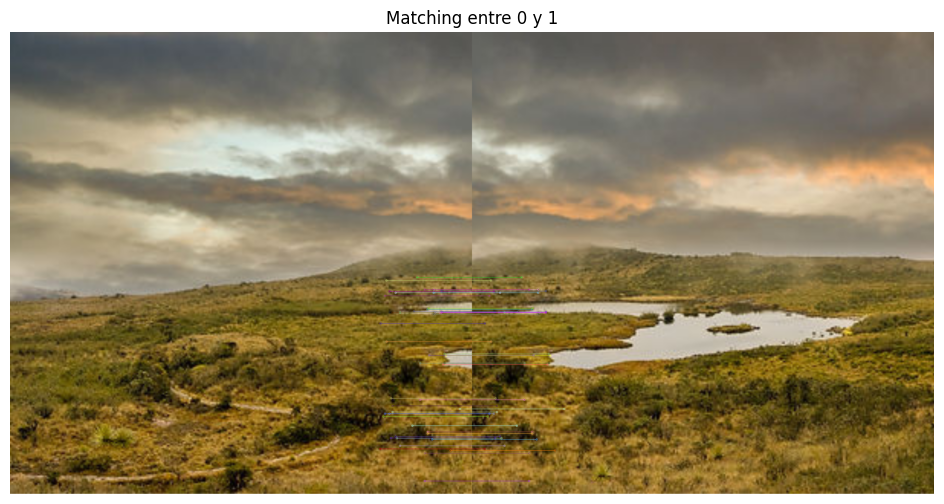

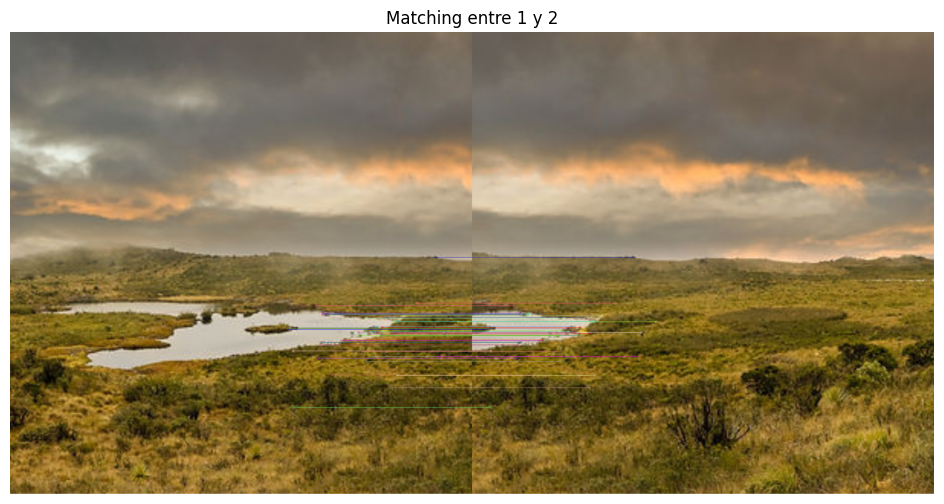

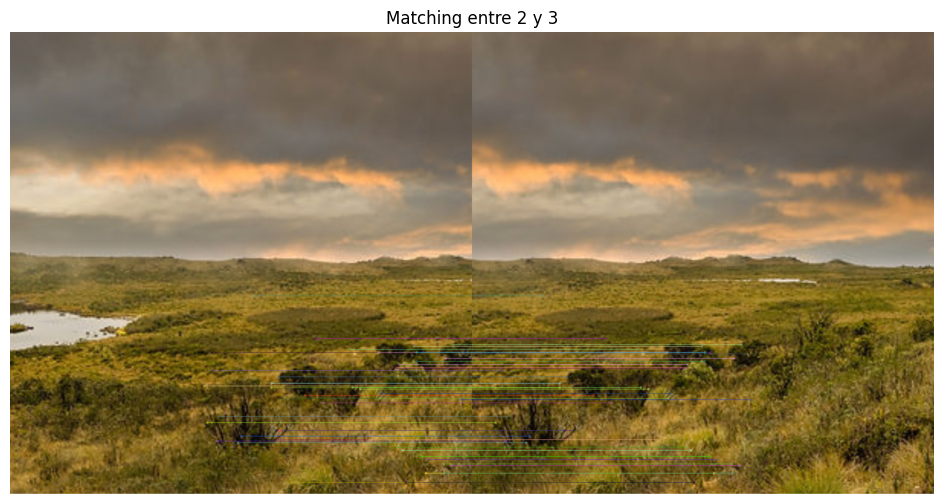

In [8]:
show_matching_pairs(images)

### 03. Wrapping

In [9]:
def warp_images(images, Hs):
    base_img = images[1]
    h, w = base_img.shape[:2]

    all_corners = []
    for i, H in enumerate(Hs):
        img = images[i]
        h_i, w_i = img.shape[:2]
        corners_i = np.array([[0, 0], [0, h_i], [w_i, h_i], [w_i, 0]], dtype=np.float32).reshape(-1,1,2)
        warped_corners = cv2.perspectiveTransform(corners_i, H)
        all_corners.append(warped_corners)

    all_corners = np.concatenate(all_corners, axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    trans = np.array([[1, 0, -xmin],
                      [0, 1, -ymin],
                      [0, 0, 1]])

    warped_imgs = []
    for i, img in enumerate(images):
        H_total = trans @ Hs[i]
        warped = cv2.warpPerspective(img, H_total, (xmax - xmin, ymax - ymin))
        warped_imgs.append(warped)

    return warped_imgs, (xmax - xmin, ymax - ymin)

In [10]:
warped_imgs, size = warp_images(images, Hs)

In [11]:
def show_warped_images_overlay(warped_imgs, canvas_size):
    h, w = canvas_size[1], canvas_size[0]
    canvas = np.zeros((h, w, 3), dtype=np.float32)

    for i, img in enumerate(warped_imgs):
        mask = (img > 0).astype(np.float32)
        canvas += img.astype(np.float32) * 0.5 * mask

    canvas = np.clip(canvas, 0, 255).astype(np.uint8)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title("wrapped images")
    plt.axis("off")
    plt.show()

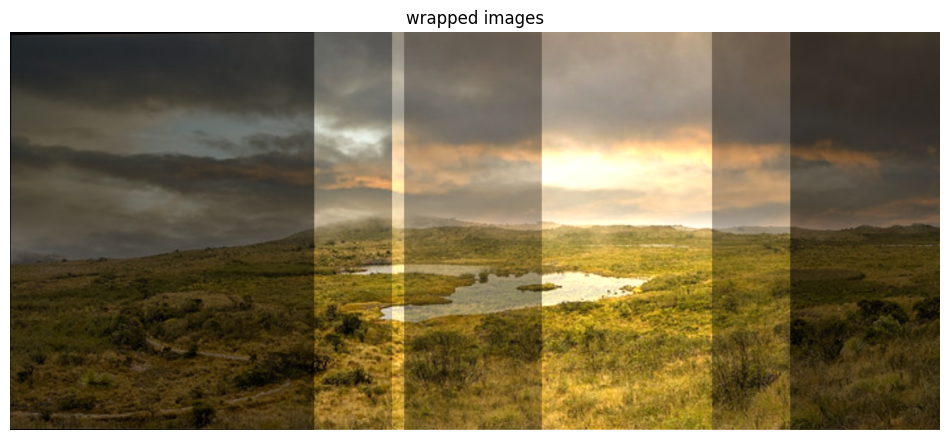

In [12]:
warped_imgs, canvas_size = warp_images(images, Hs)
show_warped_images_overlay(warped_imgs, canvas_size)

### 04. Blending

In [17]:
def blend_images(warped_imgs, size):
    height, width = size[1], size[0]
    panorama = np.zeros((height, width, 3), dtype=np.float32)
    
    weight_masks = []
    for img in warped_imgs:
        mask = (img.sum(axis=2) > 0).astype(np.float32)
        dist = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 3)
        
        if dist.max() > 0:
            dist = dist / dist.max()
        
        weight_masks.append(dist)
    
    weight_sum = np.sum(np.array(weight_masks), axis=0)
    
    for i, img in enumerate(warped_imgs):
        normalized_weight = weight_masks[i] / weight_sum
        panorama += img.astype(np.float32) * normalized_weight[:, :, np.newaxis]
    
    return panorama.astype(np.uint8)

In [18]:
panorama = blend_images(warped_imgs, size)

C:\Users\euroc\AppData\Local\Temp\ipykernel_114616\3655805572.py:18: RuntimeWarning: invalid value encountered in divide
  normalized_weight = weight_masks[i] / weight_sum
C:\Users\euroc\AppData\Local\Temp\ipykernel_114616\3655805572.py:21: RuntimeWarning: invalid value encountered in cast
  return panorama.astype(np.uint8)


## Result

In [19]:
def display_image(img, title='Result'):
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

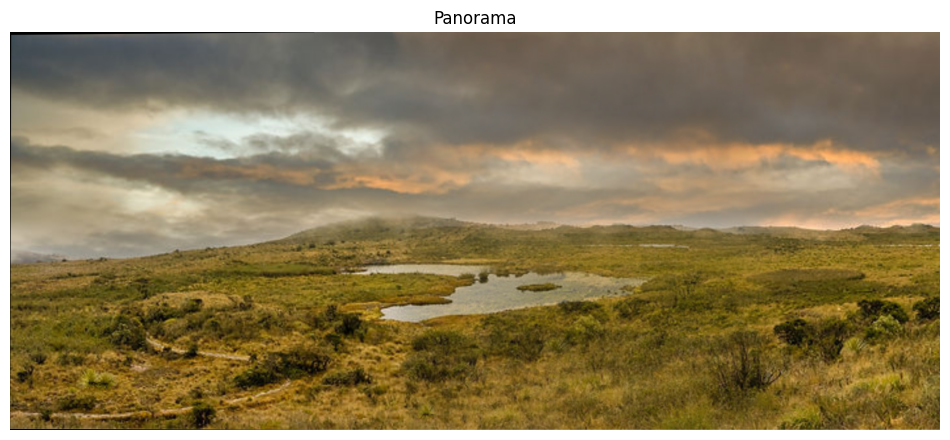

In [20]:
display_image(panorama, 'Panorama')